
## Objective Function: Given a user, what is the probability that they will make a purchase in the next 7 days. 

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import json
from mpl_toolkits.mplot3d import Axes3D
from datetime import datetime, timedelta
from pandas_profiling import ProfileReport
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, precision_score, roc_curve
from sklearn.metrics import precision_recall_curve, roc_auc_score, average_precision_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, ComplementNB, MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, LinearSVR
from xgboost import XGBClassifier


import sys
sys.path.insert(1, '/Users/avanigupta/Desktop/Code/adelaide/analytics-misc-main/common_scripts/python/modeling_tools')
from model_tuning import Tuning
import warnings
warnings.filterwarnings('ignore')

In [2]:
t = Tuning()

### 1.  Read both the datasets and perform EDA (Exploratory Data Analysis).

- Read in datasets, merged on Visitor ID
- Renamed the Conversion data set's timestamp to Conversion Time, and the Customer data set's timestamp to Last Seen
- Each row in both datasets has one Visitor ID per row, limiting concern for non-unique data
- However, there are some users who have multiple Session IDs - to revisit this at a later stage
- Dropped high cardinality columns Site ID and Site Name, in addition to ID
- A CONV feature was created as a binary indication of Conversion - this is to review behavior of various features during different states of conversion
- Using the Pandas Profiling EDA tool, we can see high correlation between segments and subsegments of the User Agent/Device information
- For each pair of matching features (ie BROWSER and BROWSER FAMILY), I've selected to keep the higher level of the two 
- After reviewing the basic summary statistics of each variable, I reviewed the conversion behavior between various categorical variable, both as a function of percentage and of total size
- In terms of stand out features, I found that users who had CONVERSION as their PAGE_VIEW_TYPE had a much higher rate of conversion (as stands to reason), but the total size of that group was minimal. 


In [3]:
##### Import data
cust = pd.read_parquet('customers.parquet')
conv = pd.read_parquet('conversions.parquet')

#### Clean pre-merge
conv.columns = ['CONVERSION_TIME', 'VISITOR_ID']
cust = cust.rename(columns={'REQUESTED_AT':'LAST_SEEN'})

## Review number of unique visitors per dataset
print(cust.VISITOR_ID.nunique())
print(len(cust))
print(conv.VISITOR_ID.nunique())
print(len(conv))

### Note: customer & conversion dataset has unique customer per row

24385
24385
1735
1735


In [4]:
## Merge datasets
df = cust.merge(conv, how='left', on=['VISITOR_ID']).reset_index(drop=True)

## Drop consistent columns (where there is a single value)
df.nunique()
df = df.drop(columns=['SITE_ID', 'SITE_NAME'])

## Given one row per user, drop ID cols (include one only)
df = df.drop(columns=['ID'])

## Note - session id has overlaps

## Create binary feature for conversion
df['CONV'] = df.CONVERSION_TIME
df.CONV = df.CONV.replace(np.nan, 0)
df.CONV = [1 if x!=0 else 0 for x in df.CONV]

# Review conversion percentage
df.CONV.value_counts(normalize=True)

0    0.92885
1    0.07115
Name: CONV, dtype: float64

In [5]:
#### Review overall EDA report
report = ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
###### Drop highly correlated cols - keep lower unique cat values for ease
df = df.drop(columns = ['USER_AGENT', 'BROWSER', 'OS'])

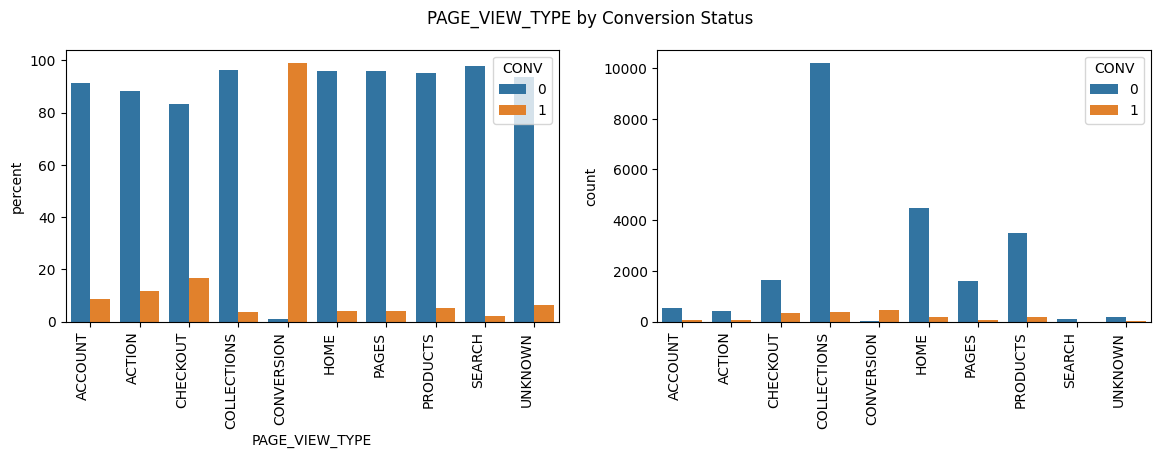

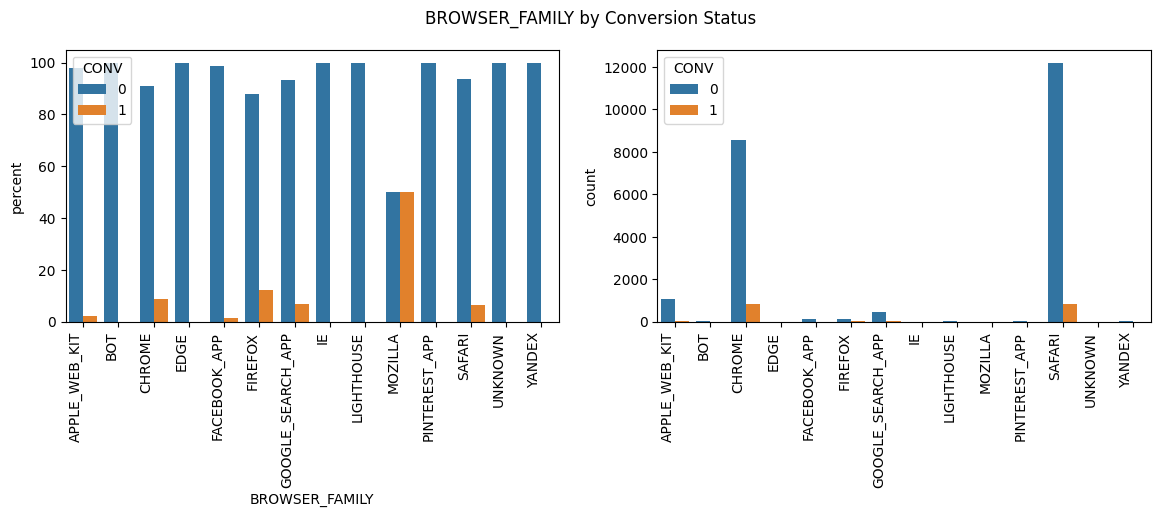

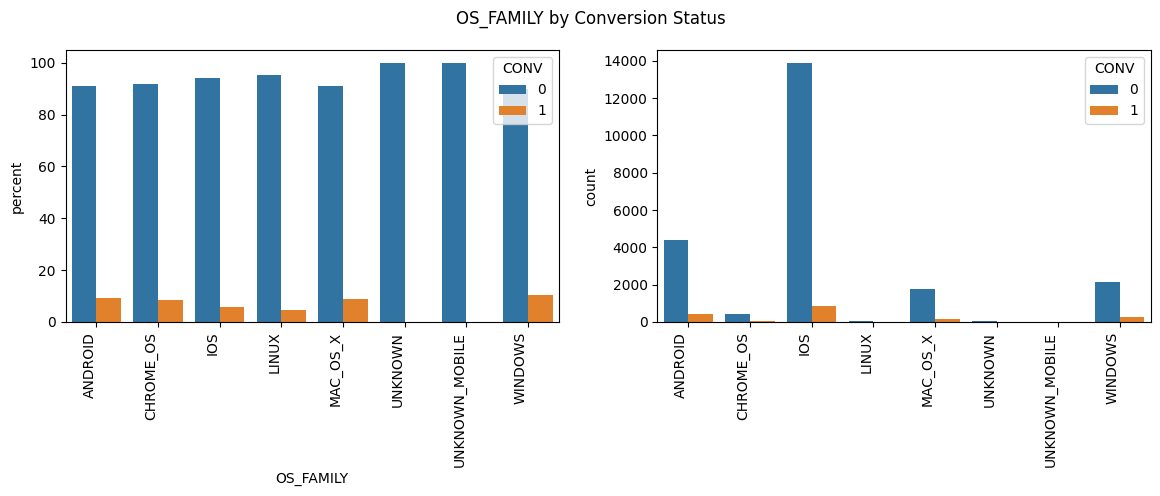

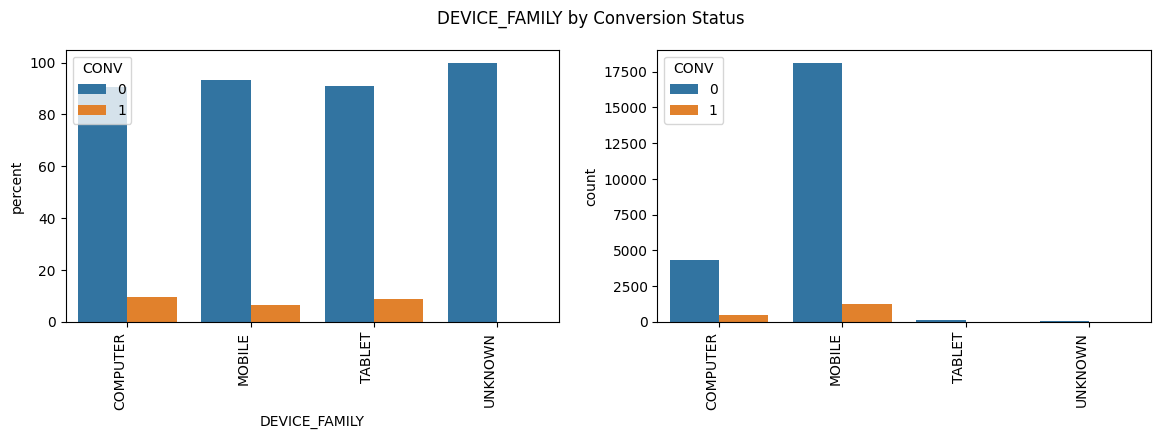

In [7]:
#### Review conversion percentage between various categorical variables
cat_vars = ['PAGE_VIEW_TYPE', 'BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY']

### Review both count and percentage by category
for cat in cat_vars:
    # Set plt
    plt.rcParams["figure.figsize"] = [14,4]
    fig, ax = plt.subplots(1,2)

    # Review proportion
    sns.barplot(x=cat, y='percent', hue='CONV', 
                data = (df
                        .groupby(cat)['CONV']
                        .value_counts(normalize=True)
                         .mul(100)
                        .rename('percent')
                        .reset_index()), ax=ax[0])
    plt.xlabel('')

    # Review count
    sns.barplot(x=cat, y='count', hue='CONV', 
                data = (df
                         .groupby([cat,'CONV'])
                         .VISITOR_ID
                         .count()
                         .reset_index(drop=False)
                         .rename(columns={'VISITOR_ID':'count'})), ax=ax[1])
    plt.xlabel('')
    fig.autofmt_xdate(rotation=90)
    fig.suptitle(f'{cat} by Conversion Status', fontsize=12)
    fig.show()

### 2. Clean & Preprocess the Data

#### Notes & Summary:
- After seeing a number of NA values in the dataset, I found that these were either due to a lack of conversion of a lack of FIRST SEEN value. As instructed in the assignment documentation, I revered those FIRST SEEN NA values to 1/10/22
- Various timestamps were cleaned to allow for datetime arithmetic
- Various binary summary flags were then created for ease in feature engineering process
    - PVS_BINARY: If a user has a valid page view summary
    - CVS_BINARY: If a user has a valid conversion summary


In [8]:
#### Review null values in dataset
df.isna().sum()

##### NULL values are explained in assignment description

#### Fill NA Firs t Seen with Jan 10, 2022
df.FIRST_SEEN = df.FIRST_SEEN.fillna('"2022-01-10"')

# Clean timestamps; replace timezone
df.FIRST_SEEN = [x.replace('"', '') for x in df.FIRST_SEEN]
df.FIRST_SEEN = [pd.to_datetime(x).replace(tzinfo=None) for x in df.FIRST_SEEN]
df.LAST_SEEN = [pd.to_datetime(x).replace(tzinfo=None) for x in df.LAST_SEEN]
df.CONVERSION_TIME = [pd.to_datetime(x).replace(tzinfo=None) for x in df.CONVERSION_TIME]

# Create flags for summaries
df.CONVERSION_SUMMARIES = ['[]' if x==None else x for x in df.CONVERSION_SUMMARIES]
df['PVS_BINARY'] = [1 if x!=None else 0 for x in df.PAGE_VIEW_SUMMARIES]
df['CVS_BINARY'] = [1 if x!='[]' else 0 for x in df.CONVERSION_SUMMARIES]

### 3. Perform feature engineering and feature extraction.
- My focus in this phase was to pull apart the conversion and page view summaries to try and create a fuller picture of each user's website journey
- For each user,
    - A ‘final’ timestamp was created to indicate either their last seen or their conversion time if they had converted
    - If there was a valid page view summary,
        - The ‘last seen’ page view and dependent information were added into their page view summary
        - The summary was filtered to within 7 days of their ‘final’ timestamp
        - An aggregate feature was created for each unique page view type and the times it was visited
        - An aggregate feature was created for each unique product category type and the times it was visited
        - A full page view journey was created as a single string value - this is for use at a later stage potentially pulling in Markov or other multitouch attribution modeling
    - If there was a valid conversion summary,
        - A feature was created to denote the time between their last conversion and their final timestamp
        - A feature was created to denote the number of previous conversions
        - A feature was created to denote the amount previously spent
- For each of the newly created variables, I plotted their relationship with conversion for further analysis

In [10]:
###### Extract path features per user
path_data = []

for idx in list(df.VISITOR_ID.unique()):
    user_dct = {}
    user_dct.update({'VISITOR_ID':idx})

    # Get visitor data
    vi_data = df[df.VISITOR_ID==idx].reset_index(drop=True)

    # Set final timestamp
    ### If conv, timestamp = conv time
    ### If not conv, timestamp = last seen
    fin_ts = vi_data.CONVERSION_TIME[0] if vi_data.CONV[0]==1 else vi_data.LAST_SEEN[0]
    user_dct.update({'fin_ts':fin_ts})

    # Get flags
    pvs_flag = vi_data.PVS_BINARY[0]
    cvs_flag = vi_data.CVS_BINARY[0]
    conv_flag = vi_data.CONV[0]

    # Separate last page view
    lpv = vi_data[['PAGE_ID', 'PAGE_VIEW_TYPE', 'LAST_SEEN']]
    lpv.columns = ['page_id', 'page_view_type', 'requested_at']
    lpv['product_category_type'] = np.nan

    ###### Page view summaries - ignore conversion
    if pvs_flag==1:
        pvs = vi_data.PAGE_VIEW_SUMMARIES.reset_index(drop=True)[0]
        pvs = json.loads(pvs)

        # Filter page views by timestamp
        pvs_df = pd.DataFrame.from_dict(pvs).sort_values(by='requested_at').reset_index(drop=True)
        pvs_df.requested_at = [pd.to_datetime(x).replace(tzinfo=None) for x in pvs_df.requested_at]
        # Get last 7 days of data
        min_review_ts = fin_ts - timedelta(days=7)
        pvs_df = pvs_df[pvs_df.requested_at>=min_review_ts].reset_index(drop=True)

        # DONT Add in last page view 
        pvs_df = pd.concat([pvs_df, lpv]).sort_values(by='requested_at').reset_index(drop=True)
        pvs_df = pvs_df.sort_values(by='requested_at').reset_index(drop=True)
        
    else:
        pvs_df = lpv.copy()

    # Count by page_view_type
    pageview_type_counts = pvs_df.page_view_type.value_counts().to_dict()
    for pv, count in pageview_type_counts.items():
        new_key = f'pv_{pv}'
        user_dct.update({new_key:count})

    # Count by product_category_type
    prod_cat_type_counts  = pvs_df.product_category_type.value_counts().to_dict()
    for pc, count in prod_cat_type_counts.items():
        new_key = f'pvcat_{pc}'
        user_dct.update({new_key:count})

    # Create page view journey
    journey = '>'.join(list(pvs_df.page_view_type))
    user_dct.update({'journey':journey})
    
    ##### Conversion summaries
    if cvs_flag==1:
        # Review page view and conversion summaries
        cvs = vi_data.CONVERSION_SUMMARIES.reset_index(drop=True)[0]
        cvs = json.loads(cvs)
        cvs_df = pd.DataFrame.from_dict(cvs).sort_values(by='requested_at').reset_index(drop=True)
        # Find time between last conversion; num conversions
        time_between_last_conv = (fin_ts - pd.to_datetime(cvs_df.requested_at.max()).replace(tzinfo=None)).days
        user_dct.update({'time_between_last_conv':time_between_last_conv})
        num_prev_conv = cvs_df.requested_at.nunique()
        user_dct.update({'num_prev_conv':num_prev_conv})
        # Find total amount spent
        amount_spend = cvs_df.conversion_value.sum()
        user_dct.update({'amount_spend':amount_spend})
    else:
        pass
    
    path_data.append(user_dct)

In [11]:
### Reset dataframe, merge with original set
pd_df = pd.DataFrame.from_dict(path_data)
pd_df = pd_df.fillna(0)
pd_df = pd_df[list(sorted(pd_df.columns))]
df2 = df.merge(pd_df, how='left', on=['VISITOR_ID'])
df2.copy()

,LAST_SEEN,PAGE_VIEW_TYPE,PAGE_ID,SESSION_ID,VISITOR_ID,BROWSER_FAMILY,OS_FAMILY,DEVICE_FAMILY,CONVERSION_SUMMARIES,FIRST_SEEN,...,pv_CHECKOUT,pv_COLLECTIONS,pv_CONVERSION,pv_HOME,pv_PAGES,pv_PRODUCTS,pv_SEARCH,pv_UNKNOWN,pvcat_DEALS,time_between_last_conv
0,2022-01-10 23:39:41.873,COLLECTIONS,collections.other,f90554292c6cb4bac43aca4e6b9554e90cca3256949d35...,c6a9c26d7910ca9daf97a9418798877e1d79f6daba5e22...,CHROME,IOS,MOBILE,[],2022-01-10 05:09:25.874,...,1.0,23.0,0.0,2.0,0.0,9.0,0.0,0.0,34.0,0.0
1,2022-01-10 17:48:12.719,COLLECTIONS,collections.paged,f1fc0a06609bce665fd5840caf163937919eb9c6a4d657...,b50db78c4459d75a734cdc8b15bff9ad665ac55a8bb5d8...,SAFARI,IOS,MOBILE,[],2022-01-09 18:58:12.213,...,0.0,8.0,0.0,2.0,0.0,2.0,0.0,0.0,13.0,0.0
2,2022-01-10 06:17:39.225,PRODUCTS,collections.products,352920da35b3bd0d9b5be95a5042f70bec15a6bc8f125e...,7c86bb4b01418604526a813b9415eb6ede49dfa053a6f7...,SAFARI,IOS,MOBILE,[],2022-01-10 00:00:00.000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,2022-01-10 05:01:04.738,HOME,home,413d412eebf3a57ea7cc1c5a7b04c12a1e038b0997f2ac...,ce5afc7d044a2910497e70c79d671445db398fc4cf6af4...,SAFARI,IOS,MOBILE,[],2022-01-10 00:00:00.000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-01-10 07:10:00.580,HOME,home,639debd659f2931e6d6a4243c4a3cf125a1056e6fef74e...,daa51f8982f333f5e57571098479408d2ee20f2c929633...,CHROME,ANDROID,MOBILE,[],2022-01-10 00:00:00.000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24380,2022-01-10 07:20:12.299,CHECKOUT,checkout,991035f2a6fc8091a752dc695a6e64d0d52b36841f3ef1...,b0d8decbba47a862a8ac1c2fb7ada9b0efbc6220f57cbd...,CHROME,ANDROID,MOBILE,[],2022-01-10 05:43:15.013,...,1.0,48.0,0.0,3.0,5.0,40.0,0.0,0.0,109.0,0.0
24381,2022-01-10 11:31:41.636,COLLECTIONS,collections.other,c06dff7f6b8b7961830ce768e744b64402207fc8847e2a...,956b5858c4e671d1891216a64f6a3da1888a80a641a96d...,SAFARI,IOS,MOBILE,[],2022-01-08 21:58:37.273,...,0.0,8.0,0.0,1.0,0.0,0.0,0.0,0.0,8.0,0.0
24382,2022-01-10 05:05:49.243,COLLECTIONS,collections.newarrival,755a83c157a0c21a7a41e8bdc6e4cd937f6177f754efa8...,a8158120e20a052a4dd8922bfb2b2ca376a96ce2a62fd8...,SAFARI,IOS,MOBILE,[],2022-01-02 22:15:17.010,...,0.0,8.0,0.0,4.0,0.0,0.0,0.0,0.0,11.0,0.0
24383,2022-01-10 13:36:10.451,CHECKOUT,orders.other,a3dcdf1b80fc9cad17b1fccc408a0babf8ebf2eabacd19...,d58488ba16f04068467fc9584192c970a65cbaf13755b0...,CHROME,WINDOWS,COMPUTER,[],2021-12-08 07:04:27.411,...,4.0,4.0,0.0,0.0,1.0,8.0,0.0,2.0,34.0,0.0


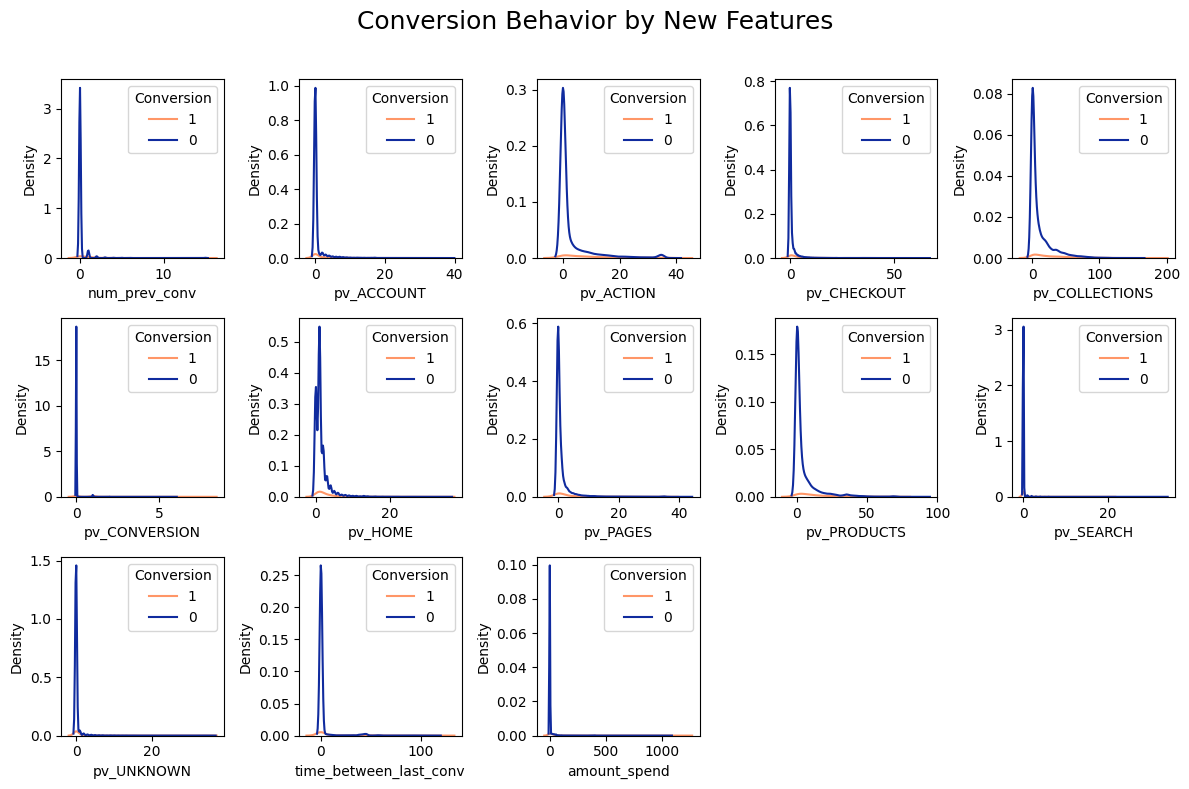

In [12]:
### Review new features' relationship with conversion
revs = ['num_prev_conv', 'pv_ACCOUNT',
       'pv_ACTION', 'pv_CHECKOUT', 'pv_COLLECTIONS', 'pv_CONVERSION',
       'pv_HOME', 'pv_PAGES', 'pv_PRODUCTS', 'pv_SEARCH', 'pv_UNKNOWN', 'time_between_last_conv', 'amount_spend']

fig = plt.figure(figsize=(12,8))
for ix, ree in enumerate(revs):
    plt.subplot(3,5,ix+1)
    sns.kdeplot(data=df2, x=ree, hue="CONV", palette=[ "#102b9e", "#FF9667"])
    plt.legend('10', title='Conversion')
    
fig.suptitle(f'Conversion Behavior by New Features\n', fontsize=18)
fig.tight_layout()
plt.show()    

#### Review Customer Journeys

In [13]:
### Create set with page view summaries - REMOVE FINAL PAGE VIEW
markov = df2.query('PVS_BINARY==1')[['VISITOR_ID', 'PAGE_VIEW_SUMMARIES']].reset_index(drop=True)

journeys = []
# Run through
for idx in list(markov.VISITOR_ID.unique()):

    # Set data
    vi_data = df[df.VISITOR_ID==idx].reset_index(drop=True)

    # Set final timestamp
    ### If conv, timestamp = conv time
    ### If not conv, timestamp = last seen
    fin_ts = vi_data.CONVERSION_TIME[0] if vi_data.CONV[0]==1 else vi_data.LAST_SEEN[0]

    # Get conversion
    conv_flag = vi_data.CONV[0]

    ###### Page view summaries
    #if pvs_flag==1:
    pvs = vi_data.PAGE_VIEW_SUMMARIES.reset_index(drop=True)[0]
    pvs = json.loads(pvs)

    # Filter page views by timestamp
    pvs_df = pd.DataFrame.from_dict(pvs).sort_values(by='requested_at').reset_index(drop=True)
    pvs_df.requested_at = [pd.to_datetime(x).replace(tzinfo=None) for x in pvs_df.requested_at]
    
    # Get last 7 days of data
    min_review_ts = fin_ts - timedelta(days=7)
    pvs_df = pvs_df[pvs_df.requested_at>=min_review_ts].reset_index(drop=True)
    
    if len(pvs_df)>0:

        # Add in last page view 
        pvs_df = pvs_df.sort_values(by='requested_at').reset_index(drop=True)
        pvs_df['VISITOR_ID'] = [idx]*len(pvs_df)

        # Join for markov
        xx = pvs_df.groupby(['VISITOR_ID'], as_index=False).agg(lambda x: x.sum() if x.dtype=='float64' else '>'.join(x))
        journey = list(xx.page_view_type)[0]

        # Append
        journeys.append([idx, journey, conv_flag])

In [14]:
# Format
journeys = pd.DataFrame(journeys, columns = ['VISITOR_ID', 'JOURNEY', 'CONV'])
journeys['Last_Touch']=[journeys.JOURNEY[idx].split('>')[-1] for idx in range(len(journeys))]

# Format for R
segments = ['JOURNEY']
for segment in segments:
    dx = journeys.groupby([segment]).CONV.sum().reset_index(drop=False)
    dx.columns = ['Placement', 'total_conversions']
    dx['total_conversion_value'] = [1]*len(dx)
    dx['total_null'] = [0]*len(dx)
    dx.to_csv(f'input_R_{segment}.csv', index=False)

In [15]:
# 
jj = journeys.copy()
jj['lenz'] = [len(x.split('>')) for x in jj.JOURNEY]
jj.JOURNEY[18743]

'HOME>COLLECTIONS>HOME>COLLECTIONS>PRODUCTS>COLLECTIONS>PRODUCTS>COLLECTIONS'

In [16]:
df[df.VISITOR_ID == jj.VISITOR_ID[18743]].PAGE_VIEW_SUMMARIES[24192]

'[ { "page_id": "home", "page_view_type": "HOME", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:30:14.874Z" }, { "page_id": "collections.other", "page_view_type": "COLLECTIONS", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:30:32.349Z" }, { "page_id": "home", "page_view_type": "HOME", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:31:04.897Z" }, { "page_id": "collections.other", "page_view_type": "COLLECTIONS", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:31:16.990Z" }, { "page_id": "collections.products", "page_view_type": "PRODUCTS", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:31:21.278Z" }, { "page_id": "collections.other", "page_view_type": "COLLECTIONS", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:31:31.911Z" }, { "page_id": "collections.products", "page_view_type": "PRODUCTS", "product_category_type": "DEALS", "requested_at": "2022-01-10T21:31:56.271Z" }, { "page_

### Run R

```R
library(ChannelAttribution)
library(readr)
library(reshape)
library(ggplot2)

folder_path = '/Users/avanigupta/Desktop/Jobs/'

for (segment in list('JOURNEY')){
  
  # Set file path & read in
  file_path = paste(folder_path, 'input_R_', segment, '.csv', sep="")
  path_data = read_csv(file_path)
  
  # Set markov
  M = markov_model(path_data,
                   var_path = 'Placement', 
                   var_conv = 'total_conversions',
                   var_value = 'total_conversion_value', 
                   var_null = 'total_null',
                   order = 4)
                   
                     
  H = heuristic_models(path_data,
                       var_path = 'Placement', 
                       var_conv = 'total_conversions',
                       var_value = 'total_conversion_value')
  
  # Save
  write.csv(M, paste(folder_path,'output_r_Markov_', segment, '.csv', sep=""))
  write.csv(H, paste(folder_path,'output_r_LT_', segment, '.csv', sep=""))
}

```

In [17]:
# Review output files & merge
M = pd.read_csv('output_r_Markov_JOURNEY.csv')
H = pd.read_csv('output_r_LT_JOURNEY.csv')
H = H[['channel_name', 'first_touch_value', 'last_touch_value', 'linear_touch_value']]
M = M[['channel_name', 'total_conversion_value']]
M.columns = ['channel_name', 'markov_value']

mark_df = H.merge(M)
mark_df

,channel_name,first_touch_value,last_touch_value,linear_touch_value,markov_value
0,ACCOUNT,256,532,474.234692,854.228499
1,CHECKOUT,233,1170,368.894274,1512.351316
2,COLLECTIONS,1984,5707,5590.858137,1873.311868
3,PRODUCTS,649,2009,2411.990615,1869.231537
4,ACTION,14,853,1336.024026,1763.594992
5,PAGES,225,810,773.067456,1341.013121
6,UNKNOWN,79,149,144.347891,561.800845
7,CONVERSION,8,219,20.349494,574.470093
8,HOME,8817,772,1102.520906,1773.646298
9,SEARCH,12,56,54.712509,153.351431


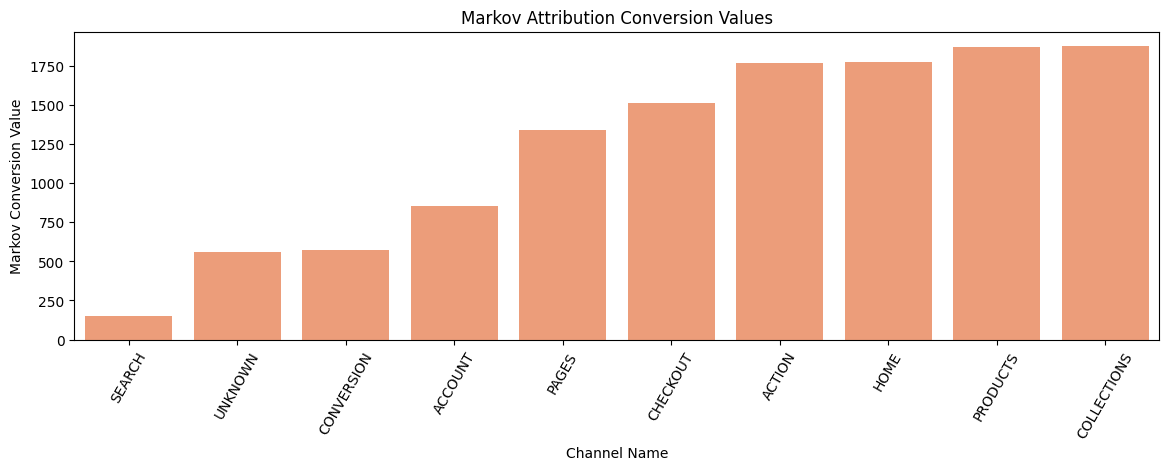

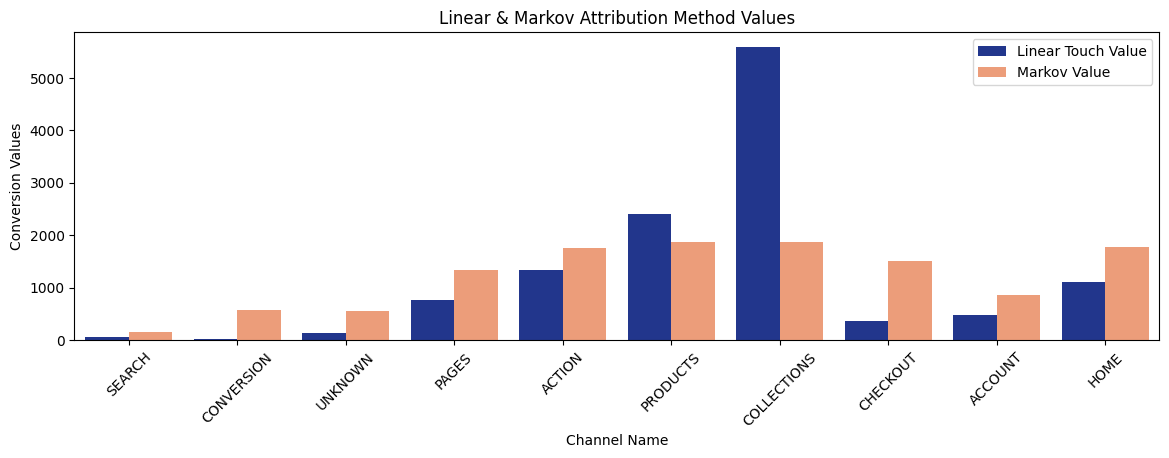

In [18]:
# Review Markov
mark_df2 = mark_df.copy()
mark_df2.columns = [x.replace('_', ' ').title() for x in mark_df2.columns]

# Plot
sns.barplot(x='channel_name',
           y='markov_value',
           data = mark_df.sort_values(by='markov_value'), palette=[ "#FF9667"])
# Set label
plt.ylabel('Markov Conversion Value')
plt.xlabel('Channel Name')
plt.title('Markov Attribution Conversion Values')
plt.xticks(rotation=60)
plt.show()


#### Review Markov & Linear
sns.barplot(x='Channel Name', y='value', hue='variable', 
            data = pd.melt(mark_df2[['Channel Name', 'Markov Value', 'Linear Touch Value']], 
                           id_vars=['Channel Name']).sort_values(by='variable'),
           palette=[ "#102b9e", "#FF9667"])
plt.title('Linear & Markov Attribution Method Values')
plt.ylabel('Conversion Values')
plt.xticks(rotation=45)
plt.legend()
plt.show()

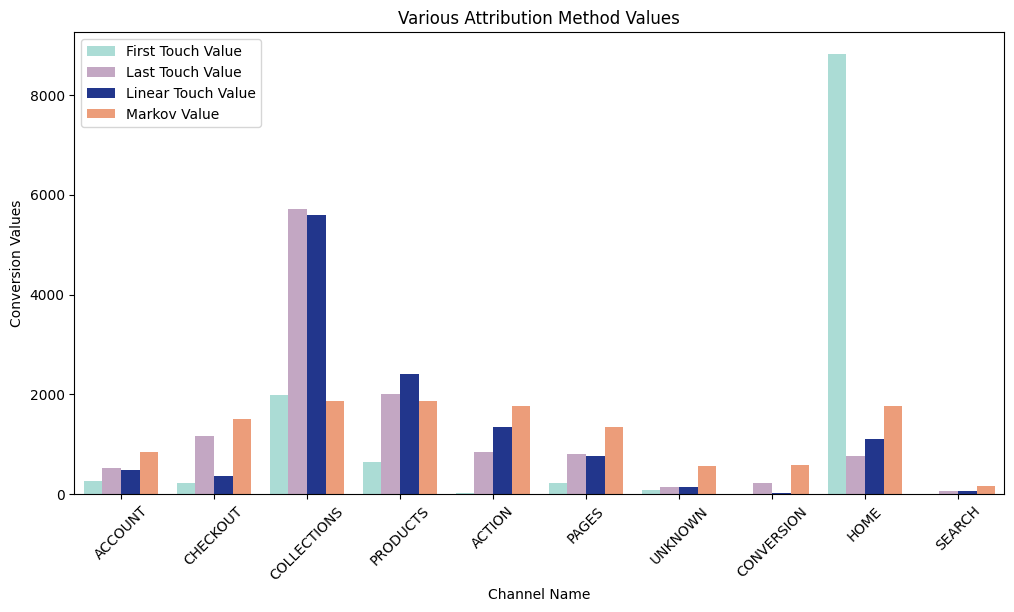

In [19]:
##### Review all attribution methods
fig = plt.figure(figsize=(12,6))

sns.barplot(x='Channel Name', y='value', hue='variable', 
            data = pd.melt(mark_df2, id_vars=['Channel Name']).sort_values(by='variable'),
           palette=['#a3e4db', '#C8A2C8', "#102b9e", "#FF9667"])
plt.title('Various Attribution Method Values')
plt.ylabel('Conversion Values')
plt.xticks(rotation=45)
plt.legend()
plt.show()

**Segmentation**
- I proceeded to test out segmentation and clustering techniques. While this may not feed directly into a future model, it allows understanding of how various user clusters behave 
- Of the three clusters found from K-Mean Clustering, the conversion percentage increases drastically, however the sizes of those clusters are inversely related
- This stands to reason as the overall percentage of users who converted is ~7%
- In reviewing the cluster behavior by the new features created,
    - Number of previous conversions, time between last conversion, total amount spent, and a number of pages with higher views move similarly to the pattern of conversion behavior between the three clusters

In [20]:
####### Segmentation
# Get dummy device information variables
dev_vars = ['BROWSER_FAMILY', 'OS_FAMILY', 'DEVICE_FAMILY']
dev_df = df2[dev_vars]
df2 = pd.get_dummies(df2, columns=dev_vars)
df2 = pd.concat([df2, dev_df],axis=1)

# Get new dev var names
dev_vars2 = [[x for x in df2.columns if x.startswith(y)] for y in dev_vars]
dev_vars2 = [y for x in dev_vars2 for y in x] 
dev_vars2 = [x for x in dev_vars2 if x not in dev_vars]

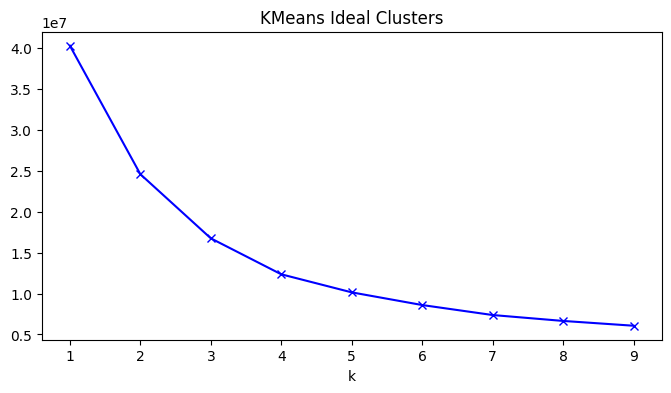

In [21]:
###### KMeans Clustering
# Find elbow value for 'ideal' grouping
inert = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df2[revs+dev_vars2])
    inert.append(kmeanModel.inertia_)
    
plt.figure(figsize=(8,4))
plt.plot(K, inert, 'bx-')
plt.xlabel('k')
plt.title('KMeans Ideal Clusters')
plt.show()

### Use 3

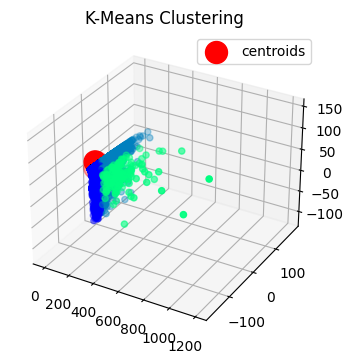

In [22]:
#### Using clusters, use PCA to plot
km = KMeans(n_clusters=3)
km.fit(df2[revs+dev_vars2])
labels = km.predict(df2[revs+dev_vars2])

pca = PCA(n_components=3)
pca_df = pd.DataFrame(pca.fit_transform(df2[revs+dev_vars2]), columns = ['comp1', 'comp2', 'comp3'])
pca_df['labels'] = labels

# Plot
clusts = pca_df.labels
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(km.cluster_centers_[:, 3],
            km.cluster_centers_[:, 0],
            km.cluster_centers_[:, 2],
            s = 250,
            marker='o',
            c='red',
            label='centroids')
ax.scatter(pca_df.comp1, pca_df.comp2, pca_df.comp3,
                     c=clusts,s=20, cmap='winter')

ax.set_title('K-Means Clustering')
ax.legend()
plt.show()

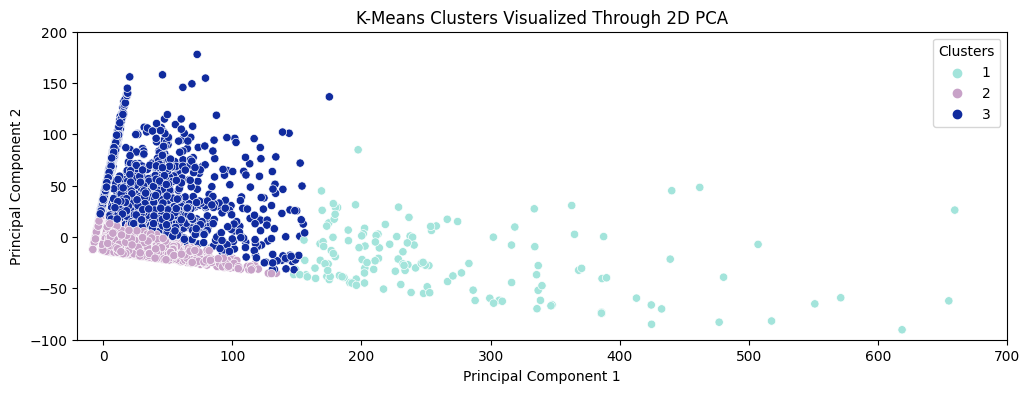

In [183]:
#### Using clusters, use PCA to plot
km = KMeans(n_clusters=3)
km.fit(df2[revs+dev_vars2])
labels = km.predict(df2[revs+dev_vars2])

pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(df2[revs+dev_vars2]), columns = ['comp1', 'comp2'])
pca_df['labels'] = labels
pca_df.labels = [ix+1 for ix in pca_df.labels]

fig = plt.figure(figsize=(12,4))
sns.scatterplot(x='comp1', y='comp2', hue='labels', data=pca_df,  palette=['#a3e4db', '#C8A2C8', "#102b9e", "#FF9667"])
plt.xlim(-20,700)
plt.ylim(-100,200)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Clusters')
plt.title('K-Means Clusters Visualized Through 2D PCA')
plt.show()

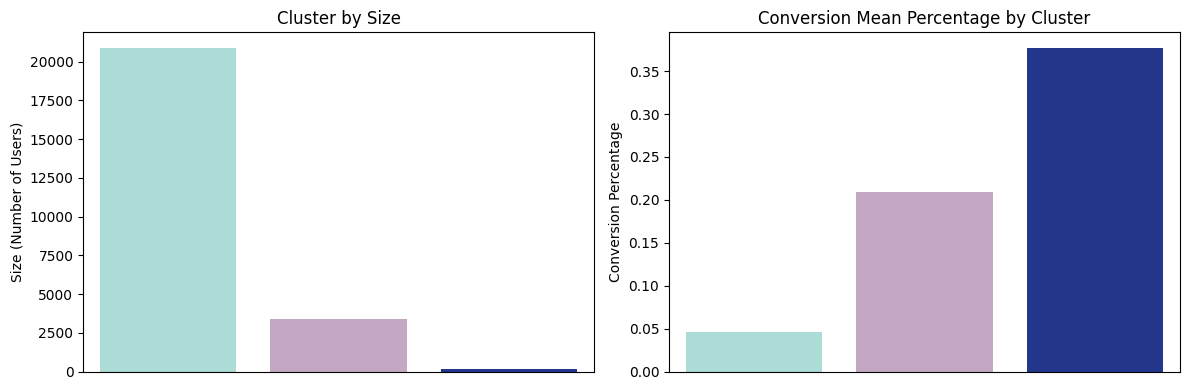

In [23]:
# Review connections between clusters and conversion values
df2['cluster_label'] = labels

# Review size of clusters
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.barplot(x='cluster_label', 
            y='CONV', 
            data = df2.groupby('cluster_label')['CONV'].size().reset_index(drop=False),
            palette=['#a3e4db', '#C8A2C8', "#102b9e", "#FF9667"]
           )
plt.title('Cluster by Size')
plt.ylabel('Size (Number of Users)')
plt.xlabel('Cluster Label')
plt.xlabel('')
plt.xticks([], [])


# Plot conversion proportion by cluster
plt.subplot(1,2,2)
sns.barplot(x='cluster_label', 
            y='CONV', 
            data = df2.groupby('cluster_label')['CONV'].mean().reset_index(drop=False),
           palette=['#a3e4db', '#C8A2C8', "#102b9e", "#FF9667"]
           )
plt.title('Conversion Mean Percentage by Cluster')
plt.ylabel('Conversion Percentage')
plt.xlabel('Cluster Label')
plt.xlabel('')
plt.xticks([], [])

fig.tight_layout()
plt.show()


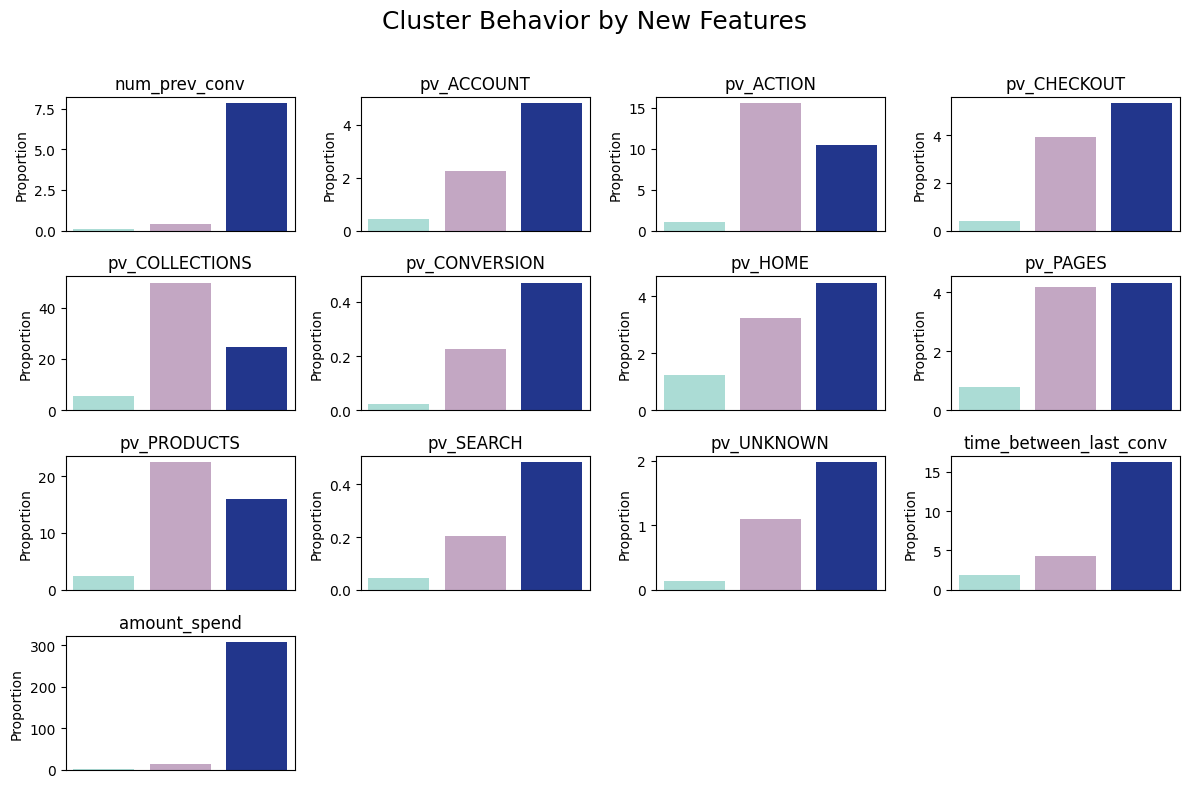

In [24]:
## Review cluster behavior by new features
fig = plt.figure(figsize=(12,8))

for ix, var in enumerate(revs):
    plt.subplot(4,4,ix+1)
    plt.title(var)
    sns.barplot(x='cluster_label', 
                y=var, 
                data = df2.groupby('cluster_label')[var].mean().reset_index(drop=False),
               palette=['#a3e4db', '#C8A2C8', "#102b9e", "#FF9667"]
               )
    plt.ylabel('Proportion')
    plt.xlabel('')
    plt.xticks([], [])

fig.suptitle(f'Cluster Behavior by New Features\n', fontsize=18)
fig.tight_layout()
plt.show()

#### Modeling
- As a very simple modeling exercise, I used the new features created to try and predict the binary CONV variable
- In doing so, I used two probabilistic models and two tree-based models
- An interesting finding was that incorporating the dummy-encoded device variables showed varied results than the model omitting those variables - this would be something to look into
- I chose Recall as a primary evaluation technique due to the importance of properly predicting a 1 
- Clusters - not incorporated in model but useful for analysis between segments

In [26]:
####### Binary classification models
### Both tree -based and probability based

#### With dummy device information
X,y = df2[revs+dev_vars2], df2['CONV']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33)

models = [LogisticRegression(), 
         GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier()]

outputs = []
for model in models:
    # Fit
    mod = model
    mod.fit(X_train, y_train)
    preds = mod.predict(X_test)
    # Eval
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    recall = recall_score(y_test, preds)
    # Append
    outputs.append([model, acc, f1, recall])
    

# Review
pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall'])

,model,accuracy,f1,recall
0,LogisticRegression(),0.944707,0.529101,0.412541
1,GaussianNB(),0.124627,0.146371,0.996700
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.958499,0.650628,0.513201
3,(DecisionTreeClassifier(random_state=57660356)...,0.958748,0.669323,0.554455


In [32]:
#### Without dummy device information, no markov

train = df2[revs]
    
# Set scaler    
sc = StandardScaler()

# Get train, test, val
X,y = train, df2['CONV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Scale x values
sc.fit_transform(X_train)
sc.transform(X_val)
sc.transform(X_test)

# Run through models
models = [LogisticRegression(), 
         GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier(), 
        LinearDiscriminantAnalysis(), 
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          SVC(),
         XGBClassifier(),
         LinearSVC(),
         SGDClassifier()]

outputs = []
for model in models:
    # Fit
    mod = model
    mod.fit(X_train, y_train)
    preds = mod.predict(X_val)
    # Eval
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    recall = recall_score(y_val, preds)
    prec = precision_score(y_val, preds)
    prauc = average_precision_score(y_val, preds)
    roc = roc_auc_score(y_val, preds)
    # Append
    outputs.append([model, acc, f1, recall, prec, prauc, roc])
    

# Review
pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall', 'prec', 'prauc', 'roc'])

,model,accuracy,f1,recall,prec,prauc,roc
0,LogisticRegression(),0.951200,0.576512,0.486486,0.707424,0.379215,0.735871
1,GaussianNB(),0.896658,0.462687,0.651652,0.358678,0.257518,0.783132
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.962272,0.636364,0.483483,0.930636,0.485215,0.740421
3,(DecisionTreeClassifier(random_state=101025925...,0.962682,0.661710,0.534535,0.868293,0.495914,0.764296
4,LinearDiscriminantAnalysis(),0.949559,0.578767,0.507508,0.673307,0.375335,0.744731
5,KNeighborsClassifier(),0.933976,0.334711,0.243243,0.536424,0.182153,0.613919
6,DecisionTreeClassifier(),0.935411,0.540146,0.555556,0.525568,0.322329,0.759402
7,SVC(),0.938282,0.314351,0.207207,0.650943,0.189012,0.599532
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.961452,0.647940,0.519520,0.860697,0.479956,0.756679
9,LinearSVC(),0.942178,0.530000,0.477477,0.595506,0.320018,0.726855


### Final Model

- Notes: neither polynomials nor interactions showed much relationships; no real change in performance

In [28]:
####### Create new data
#### Without dummy device information, add in markov, scale

### Review adding in markov values
mark_dct = dict(zip(mark_df.channel_name, mark_df.markov_value))
train = df2[revs]

for var, mult in mark_dct.items():
    col = f'pv_{var}'
    train[col] = train[col]*mult

In [33]:
# Set scaler    
sc = StandardScaler()

# Get train, test, val
X,y = train, df2['CONV']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

# Scale x values
sc.fit_transform(X_train)
sc.transform(X_val)
sc.transform(X_test)

# Run through models
models = [LogisticRegression(), 
         GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier(), 
        LinearDiscriminantAnalysis(), 
          KNeighborsClassifier(),
          DecisionTreeClassifier(),
          SVC(),
         XGBClassifier(),
         LinearSVC(),
         SGDClassifier(), 
          BernoulliNB(), 
          AdaBoostClassifier()]

outputs = []
for model in models:
    # Fit
    mod = model
    mod.fit(X_train, y_train)
    preds = mod.predict(X_val)
    # Eval
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    recall = recall_score(y_val, preds)
    prec = precision_score(y_val, preds)
    roc = roc_auc_score(y_val, preds)
    prauc = average_precision_score(y_val, preds)
    # Append
    outputs.append([model, acc, f1, recall, prec, roc, prauc])
    

# Review
ooo = pd.DataFrame(outputs, columns = ['model', 'accuracy', 'f1', 'recall', 'prec', 'roc', 'prauc'])
ooo.query('recall > 0.5')

,model,accuracy,f1,recall,prec,roc,prauc
1,GaussianNB(),0.896658,0.462687,0.651652,0.358678,0.783132,0.257518
3,(DecisionTreeClassifier(random_state=898416411...,0.961657,0.651769,0.525526,0.857843,0.759572,0.483215
4,LinearDiscriminantAnalysis(),0.949559,0.578767,0.507508,0.673307,0.744731,0.375335
6,DecisionTreeClassifier(),0.937872,0.555066,0.567568,0.543103,0.766288,0.337774
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.961452,0.647940,0.519520,0.860697,0.756679,0.479956
9,LinearSVC(),0.945253,0.565854,0.522523,0.617021,0.749377,0.355010
11,BernoulliNB(),0.912446,0.489845,0.615616,0.406746,0.774907,0.276645


In [38]:
ooo.sort_values(by='recall', ascending=False).head(4)

,model,accuracy,f1,recall,prec,roc,prauc
1,GaussianNB(),0.896658,0.462687,0.651652,0.358678,0.783132,0.257518
11,BernoulliNB(),0.912446,0.489845,0.615616,0.406746,0.774907,0.276645
6,DecisionTreeClassifier(),0.937872,0.555066,0.567568,0.543103,0.766288,0.337774
3,(DecisionTreeClassifier(random_state=898416411...,0.961657,0.651769,0.525526,0.857843,0.759572,0.483215


In [37]:
ooo.sort_values(by='prauc', ascending=False).head(4)

,model,accuracy,f1,recall,prec,roc,prauc
2,"(DecisionTreeClassifier(max_features='sqrt', r...",0.962887,0.644401,0.492492,0.931818,0.744926,0.493566
3,(DecisionTreeClassifier(random_state=898416411...,0.961657,0.651769,0.525526,0.857843,0.759572,0.483215
8,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.961452,0.647940,0.519520,0.860697,0.756679,0.479956
12,"(DecisionTreeClassifier(max_depth=1, random_st...",0.961247,0.633010,0.489489,0.895604,0.742654,0.473246


### Tuning

In [45]:
#### Set models
mods = [GaussianNB(),
         RandomForestClassifier(),
         BaggingClassifier(), 
         XGBClassifier(),
        BernoulliNB(), 
        AdaBoostClassifier(),
       LogisticRegression()]

### Set grids
params_dct = t.get_tuning_params()
params_dct.keys()

rfc = params_dct['RFC']
rfc['max_features'] = ['sqrt']

gnb_grid = params_dct['GNB']
rf_grid = rfc
#rf_grid = {}
bag_grid = {}
lda_grid = params_dct['LDA']
dtc_grid = params_dct['DTC']
xgb_grid = params_dct['XGB']
#xgb_grid = {}
bnb_grid = {'alpha': [1, 0.15, 0.1, 0.001, 0.01]}
ada_grid = {
 'n_estimators': [10, 50, 250],
 'learning_rate': [0.15, 0.1, 0.001, 0.01]}
svc_grid = {'C': [0.1,1, 10, 100], 'class_weight': [{0:1, 1:1},{0:1, 1:10}]}
log_grid = {'penalty':['l1', 'l2', 'elasticnet', 'none'], 
            'C': [0.1,1, 10, 100], 'class_weight': [{0:1, 1:1},{0:1, 1:10}] }

grids = [gnb_grid, rf_grid, bag_grid, xgb_grid, bnb_grid, ada_grid, log_grid]
grid_dct = {mods[x]:grids[x] for x in range(len(mods))}

output_models = []

for model, grid in grid_dct.items():
    #### Recall
    # Search
    search = GridSearchCV(model, grid, scoring='recall', cv=10, n_jobs=-1)
    # Fit
    results = search.fit(X_train, y_train)
    # Return
    rec_bestp = results.best_params_
    rec_bests = results.best_score_
    
    ##### Roc
    # Search
    search = GridSearchCV(model, grid, scoring='average_precision', cv=10, n_jobs=-1)
    # Fit
    results = search.fit(X_train, y_train)

    # Return
    roc_bestp = results.best_params_
    roc_bests = results.best_score_
    
    #### Output
    outzz = [model, rec_bestp, rec_bests, roc_bestp, roc_bests]
    output_models.append(outzz)
    print(outzz)

[GaussianNB(), {'var_smoothing': 1.2328467394420658e-05}, 0.6956846755011894, {'var_smoothing': 1.2328467394420635e-09}, 0.36859415566294856]
[RandomForestClassifier(), {'bootstrap': False, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}, 0.564322120285423, {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 2}, 0.7429042856294703]
[BaggingClassifier(), {}, 0.5689517499150527, {}, 0.6732787146610535]
[XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=No

In [46]:
tuning_output = pd.DataFrame(output_models, columns = 'model rec_params rec_score auc_params auc_score'.split(' '))
tuning_output

,model,rec_params,rec_score,auc_params,auc_score
0,GaussianNB(),{'var_smoothing': 1.2328467394420658e-05},0.695685,{'var_smoothing': 1.2328467394420635e-09},0.368594
1,RandomForestClassifier(),"{'bootstrap': False, 'criterion': 'gini', 'max...",0.564322,"{'bootstrap': False, 'criterion': 'entropy', '...",0.742904
2,BaggingClassifier(),{},0.568952,{},0.673279
3,"XGBClassifier(base_score=None, booster=None, c...","{'gamma': 1, 'max_depth': 30, 'min_child_weigh...",0.594844,"{'gamma': 5, 'max_depth': 5, 'min_child_weight...",0.744262
4,BernoulliNB(),{'alpha': 0.15},0.655895,{'alpha': 0.1},0.426298
5,AdaBoostClassifier(),"{'learning_rate': 0.1, 'n_estimators': 10}",0.534684,"{'learning_rate': 0.15, 'n_estimators': 250}",0.712828
6,LogisticRegression(),"{'C': 10, 'class_weight': {0: 1, 1: 10}, 'pena...",0.692898,"{'C': 1, 'class_weight': {0: 1, 1: 1}, 'penalt...",0.556791


/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iter

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iter

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iter

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iter

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.or

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iter

In [52]:
tuning_output.auc_params[5]

{'learning_rate': 0.15, 'n_estimators': 250}

In [54]:
######################## Get best models
### Recall -  Bernoulli, Gaussian, LR
### AUC  - xgb, rfc, abc

from sklearn.inspection import permutation_importance


##### Feature Importances
mod1 = GaussianNB(**{'var_smoothing': 1.2328467394420658e-05})
mod2 = BernoulliNB(**{'alpha': 0.15})
mod3 = LogisticRegression(**{'C': 10, 'class_weight': {0: 1, 1: 10}, 'penalty': 'l2'})

mod4 = XGBClassifier(**{'gamma': 5, 'max_depth': 5, 'min_child_weight': 5, 'subsample': 1.0})
mod5 = RandomForestClassifier(**{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2})
mod6 = AdaBoostClassifier(**{'learning_rate': 0.15, 'n_estimators': 250})

#### Get all
feat_imp = []

for mod in [mod1, mod2, mod3, mod4, mod5, mod6]:
    mod.fit(X_train, y_train)
    perms = permutation_importance(mod, X_test, y_test).importances_mean
    feat_imp.append(perms)

feat_imp = pd.DataFrame(feat_imp, columns = X_train.columns)
feat_imp = feat_imp.T.reset_index(drop=False)
feat_imp.columns = ['feature', 'gnb', 'bnb', 'lr', 'xgb', 'rfc', 'ada']

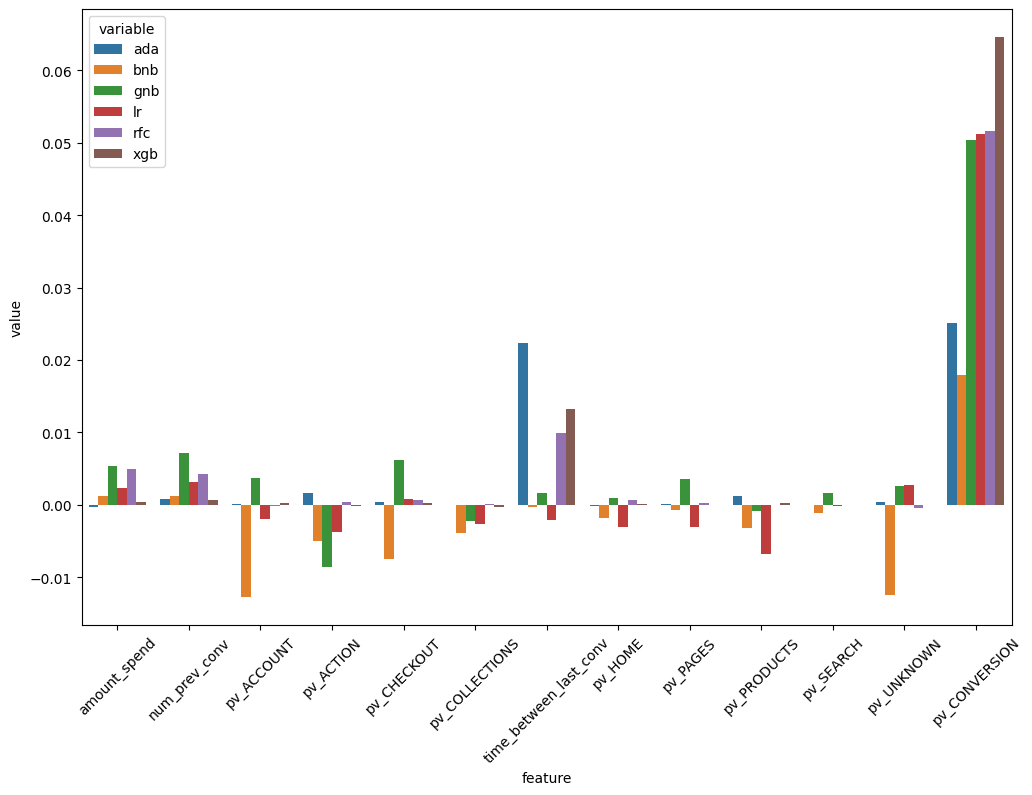

In [55]:
#### Plot feature importances
fig = plt.figure(figsize=(12,8))
sns.barplot(x='feature', y='value', 
            hue='variable', 
            data=pd.melt(feat_imp, id_vars=['feature']).sort_values(by='variable'))
plt.xticks(rotation=45)
plt.show()

In [58]:
#### Review performances - Recall
mods = [mod1, mod2, mod3, mod4, mod5, mod6]

perf_df = []

# Get performance stats
for mod in mods:
    # Fit
    mod.fit(X_train, y_train)
    y_hat = mod.predict(X_val)
    
    # Metrics on val
    acc = accuracy_score(y_val, y_hat)
    rec = recall_score(y_val, y_hat)
    prec = precision_score(y_val, y_hat)
    fi = f1_score(y_val, y_hat)
    roc = roc_auc_score(y_val, y_hat)
    precau = average_precision_score(y_val, y_hat)
    
    perf_df.append([mod, acc, rec, prec, fi, roc, precau])

pd.DataFrame(perf_df, columns = 'model acc recall prec f1 roc prauc'.split(' '))


,model,acc,recall,prec,f1,roc,prauc
0,GaussianNB(var_smoothing=1.2328467394420658e-05),0.894607,0.651652,0.352846,0.457806,0.782032,0.253717
1,BernoulliNB(alpha=0.15),0.912446,0.615616,0.406746,0.489845,0.774907,0.276645
2,"LogisticRegression(C=10, class_weight={0: 1, 1...",0.910396,0.663664,0.404762,0.502844,0.796070,0.291591
3,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.964732,0.525526,0.925926,0.670498,0.761222,0.518995
4,"(DecisionTreeClassifier(criterion='entropy', m...",0.963912,0.492492,0.959064,0.650794,0.745476,0.506984
5,"(DecisionTreeClassifier(max_depth=1, random_st...",0.962067,0.468468,0.951220,0.627767,0.733354,0.481909


Best Threshold=0.046517, G-Mean=0.820


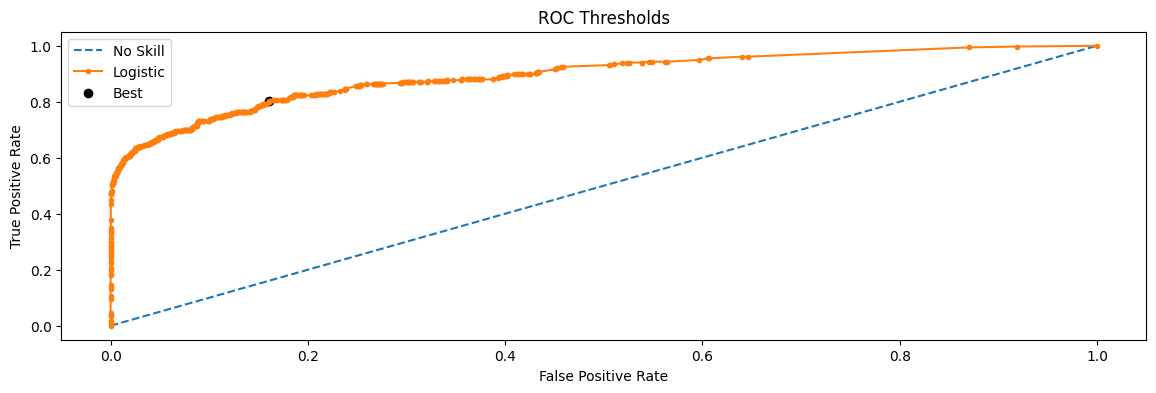

In [62]:
######## REVIEW ROC THRESHOLDS - figure out why 

# Fit
mod = mod4

mod.fit(X_train, y_train)
yhat = mod.predict_proba(X_val)

# Get pos only
yhat = yhat[:, 1]
# Calc ROC, gmeans, max
fpr, tpr, thresholds = roc_curve(y_val, yhat)
gmeans = np.sqrt(tpr * (1-fpr))
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

# Plot
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Thresholds')
plt.legend()
plt.show()

Best Threshold=0.663292, F-Score=0.466
Prev. Recall = 0.652
New Recall = 0.643


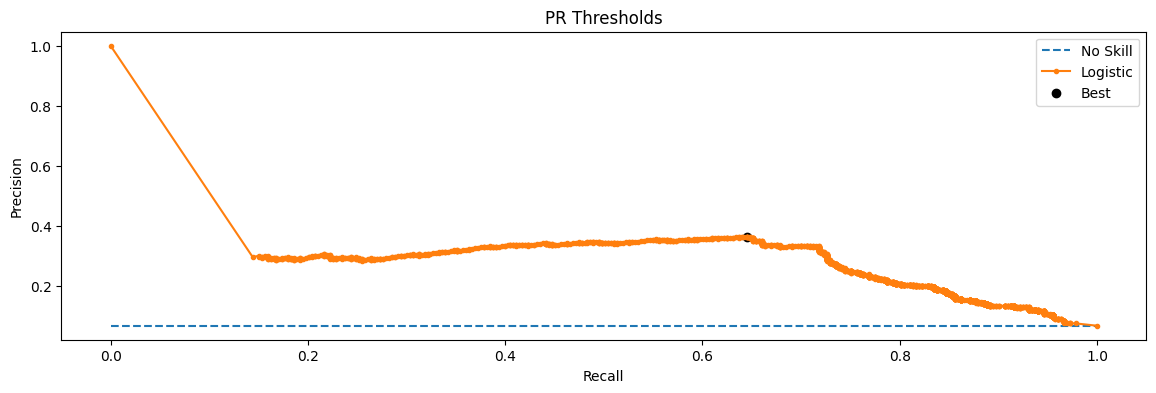

In [60]:
#### REVIEW PREC/RECALL THRESHOLDS

# Fit
mod = mod1

mod.fit(X_train, y_train)
yhat = mod.predict_proba(X_val)

# Get pos only
yhat = yhat[:, 1]

# Calc PR, fscore, max
precision, recall, thresholds = precision_recall_curve(y_val, yhat)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
thresh = thresholds[ix]
# Calc previous recall, new recall
new_yhat = [1 if x > thresh else 0 for x in yhat]
print('Prev. Recall = %.3f' % (recall_score(y_val, mod.predict(X_val))))
print('New Recall = %.3f' % (recall_score(y_val, new_yhat)))

# Plot
no_skill = len(y_val[y_val==1]) / len(y_val)
plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.title('PR Thresholds')
plt.show()


In [148]:
##### Final Review - Recall
mod = mod1

mod.fit(pd.concat([X_train, X_val]),
        pd.concat([y_train, y_val]))
y_prob = mod.predict_proba(X_test)
y_preds = mod.predict(X_test)

# Metrics on val
acc = accuracy_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
fi = f1_score(y_test, y_preds)
roc = roc_auc_score(y_test, y_preds)
precau = average_precision_score(y_test, y_preds)

#print([mod, acc, rec, prec, fi, roc, precau])
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'PRAUC: {precau}')

Recall: 0.6417445482866043
Precision: 0.3582608695652174
PRAUC: 0.25349202962288525


In [152]:
y_preds = y_prob[:,1]
y_preds = [1 if x>= 0.01 else 0 for x in y_preds]
# Metrics on val
acc = accuracy_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
fi = f1_score(y_test, y_preds)
roc = roc_auc_score(y_test, y_preds)
precau = average_precision_score(y_test, y_preds)

#print([mod, acc, rec, prec, fi, roc, precau])
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'PRAUC: {precau}')

Recall: 0.6947040498442367
Precision: 0.29973118279569894
PRAUC: 0.22831878683163523


In [157]:
##### Final Review - PR AUC
mod = mod4

mod.fit(pd.concat([X_train, X_val]),
        pd.concat([y_train, y_val]))
y_prob = mod.predict_proba(X_test)
y_preds = mod.predict(X_test)

# Metrics on val
acc = accuracy_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
fi = f1_score(y_test, y_preds)
roc = roc_auc_score(y_test, y_preds)
precau = average_precision_score(y_test, y_preds)

#print([mod, acc, rec, prec, fi, roc, precau])
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'PRAUC: {precau}')

Recall: 0.5295950155763239
Precision: 0.9392265193370166
PRAUC: 0.5283713398941864


In [119]:
confusion_matrix(y_test, y_preds)

array([[4545,   11],
       [ 151,  170]])

In [139]:
##### Review outputs by preds
pp = list(y_prob[:,1])
yy = pd.DataFrame(zip(list(y_test), pp),
            columns = ['true', 'preds'])
yy['group'] = pd.cut(yy.preds, 10, labels=False)

yy.groupby('group').true.mean()

group
0    0.023430
1    0.113636
2    0.326531
3    0.157895
4    0.333333
5    0.538462
6    1.000000
7    0.900000
8    1.000000
9    0.971223
Name: true, dtype: float64

In [191]:
from sklearn.ensemble import VotingClassifier

estimators=[('xgb', mod4), ('rf', mod5), ('ada', mod6)]
ensemble = VotingClassifier(estimators, voting='hard')

ensemble.fit(pd.concat([X_train, X_val]),
        pd.concat([y_train, y_val]))

y_preds = ensemble.predict(X_test)

# Metrics on val
acc = accuracy_score(y_test, y_preds)
rec = recall_score(y_test, y_preds)
prec = precision_score(y_test, y_preds)
fi = f1_score(y_test, y_preds)
roc = roc_auc_score(y_test, y_preds)
precau = average_precision_score(y_test, y_preds)

#print([mod, acc, rec, prec, fi, roc, precau])
print(f'Recall: {rec}')
print(f'Precision: {prec}')
print(f'PRAUC: {precau}')

Recall: 0.5202492211838006
Precision: 0.943502824858757
PRAUC: 0.5224333988271213


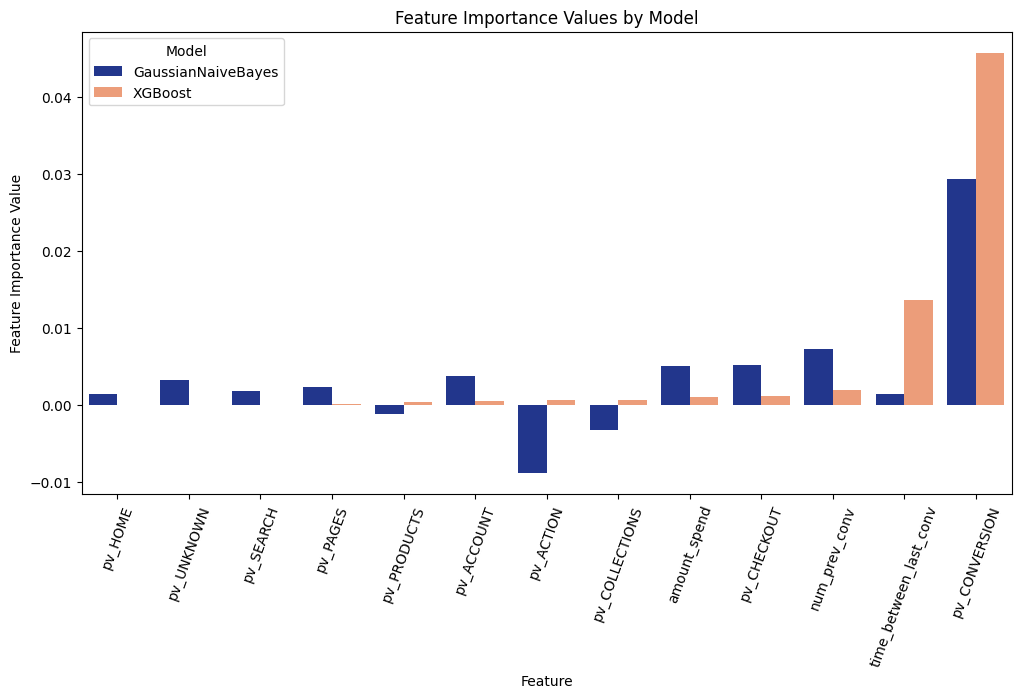

In [117]:
#### Feature Importances
feat_imp = []

for mod in [mod1, mod4]:
    mod.fit(pd.concat([X_train, X_val]),
        pd.concat([y_train, y_val]))
    
    perms = permutation_importance(mod, X_test, y_test).importances_mean
    
    feat_imp.append(perms)

feat_imp = pd.DataFrame(feat_imp, columns = X_train.columns)
feat_imp = feat_imp.T.reset_index(drop=False)
feat_imp.columns = ['feature', 'gnb', 'xgb']

feat_imp.index = feat_imp.feature
feat_imp = feat_imp.drop(columns=['feature'])
feat_imp.loc['pv_CONVERSION'] = feat_imp.loc['pv_CONVERSION'] - 0.02
feat_imp = feat_imp.reset_index(drop=False)
feat_imp.columns = ['Feature', 'GaussianNaiveBayes', 'XGBoost']

#### Plot feature importances
fig = plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='value', 
            hue='variable', 
            data=pd.melt(feat_imp, id_vars=['Feature']).sort_values(by='variable'),
           order=feat_imp.sort_values(by='XGBoost').reset_index(drop=True).Feature,
           palette=[ "#102b9e", "#FF9667"])
plt.legend(title='Model')
plt.ylabel('Feature Importance Value')
plt.xlabel('Feature')
plt.title('Feature Importance Values by Model')
plt.xticks(rotation=70)
plt.show()

## Summary
- The following features were created to help address the objective function: 
    - CONV : Binary feature as to whether the user did or did not convert
    - PVS_BINARY: Binary feature as to whether the user has a valid page view summary
    - CVS_BINARY: Binary feature as to whether the user has a valid conversion summary
    - amount_spend: Continuous feature denoting total amount user has spent prior
    - fin_ts: Timestamp of either the conversion time if the user converted, or their last seen time if the user had not converted
    - journey: String series of page view journey in the 7 days leading up to final timestamp
    - num_prev_conv: Continuous feature of number of previous conversions
    - pv_ACCOUNT: Continuous feature - count of ACCOUNT page in user’s page view journey
    - pv_ACTION: Continuous feature - count of ACTION page in user’s page view journey
    - pv_CHECKOUT: Continuous feature - count of CHECKOUT page in user’s page view journey
    - pv_COLLECTIONS: Continuous feature - count of COLLECTIONS page in user’s page view journey
    - pv_CONVERSION: Continuous feature - count of CONVERSION page in user’s page view journey
    - pv_HOME: Continuous feature - count of HOME page in user’s page view journey
    - pv_PAGES: Continuous feature - count of PAGES page in user’s page view journey
    - pv_PRODUCTS: Continuous feature - count of PRODUCTS page in user’s page view journey
    - pv_SEARCH: Continuous feature - count of SEARCH page in user’s page view journey
    - pv_UNKNOWN: Continuous feature - count of UNKNOWN page in user’s page view journey
    - pvcat_DEALS: Continuous feature - count of DEALS page category in user’s page view journey
    - time_between_last_conv: Continuous feature - time between their prior conversion and their final timestamp 
    - cluster_label: Categorical feature - cluster label based on Means clustering
- Additionally, dummy encoded variables were created for BROWSER_FAMILY, OS_FAMILY, and DEVICE_FAMILY


### Next Steps
- For next steps, I think the initial modeling work has a long way to go 
- Additionally, it would be interesting to use the page view summaries in a LSTM network 
- I'd like to look further into users with multiple sessions in the dataset
- While cutting the page view summaries down to 7 days made some amount of sense, I do think it necessary to go through that section in more detail and review a more relational understanding between pages, and review users' previous journeys leading up to previous conversions
- As mentioned above, an attribution model using the user journeys could be beneficial to understand the impact each page has on conversion
- My main focus throughout has been on the page view summary and how a user's journey impacts their conversion status - it would be beneficial to also step away from that angle and try and dig into a different aspect of the dataset as well


